In [1]:
from covariance_analysis import *
from IPython.display import Markdown
from numpy import linalg as LA
from models import predict_with_existing

from pria_lifechem.function import *
from pria_lifechem.evaluation import *
from pria_lifechem.models.deep_classification import *

from sklearn.manifold import TSNE

Using Theano backend.
Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
running_index = 1
k = 5
pos_num = 50
neg_num = 200

# Get Input Feature

In [4]:
directory = '~/virtual-screening/dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('{}file_{}.csv'.format(directory, i))
file_list = np.array(file_list)

# read data
test_index = running_index / 4
val_index = running_index % 4 + (running_index % 4 >= test_index)
complete_index = np.arange(k)
train_index = np.where((complete_index != test_index) & (complete_index != val_index))[0]

train_file_list = file_list[train_index]
val_file_list = file_list[val_index:val_index+1]
test_file_list = file_list[test_index:test_index+1]

In [5]:
label_name_list = ['Keck_Pria_AS_Retest']

train_pd = filter_out_missing_values(read_merged_data(train_file_list), label_list=label_name_list)
val_pd = filter_out_missing_values(read_merged_data(val_file_list), label_list=label_name_list)
test_pd = filter_out_missing_values(read_merged_data(test_file_list), label_list=label_name_list)

# extract data, and split training data into training and val
X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=label_name_list)
X_val, y_val = extract_feature_and_label(val_pd,
                                         feature_name='Fingerprints',
                                         label_name_list=label_name_list)
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=label_name_list)

(43453, 1)
(14484, 1)
(14486, 1)


In [6]:
pos_index_list = sample_index(y_train, 1, pos_num)
neg_index_list = sample_index(y_train, 0, neg_num)
pos_num = pos_index_list.shape[0]
neg_num = neg_index_list.shape[0]
N = pos_num + neg_num
print 'Extract {} pos\t{} neg'.format(pos_num, neg_num)

Extract 47 pos	200 neg


In [7]:
sample_pos_X = X_train[pos_index_list]
sample_neg_X = X_train[neg_index_list]
feature_X = np.vstack((sample_pos_X, sample_neg_X))
print feature_X.shape

(247, 1024)


# Test Single-task Covariance Matrix

In [8]:
with open('../virtual-screening/output/cross_validation/single_classification_22.json', 'r') as f:
    conf = json.load(f)
single_task = SingleClassification(conf=conf)

In [9]:
PMTNN_weight_file = '../virtual-screening/output/cross_validation/single_classification_22/45540945/{}.weight'.format(running_index)
print PMTNN_weight_file
single_task.predict_with_existing(X_train, y_train, X_val, y_val, X_test, y_test,
                           PMTNN_weight_file=PMTNN_weight_file)

../virtual-screening/output/cross_validation/single_classification_22/45540945/1.weight

train precision: 0.998314670017
train roc: 0.999998039294
train bedroc: 0.994706144082

validation precision: 0.307938220156
validation roc: 0.783930484518
validation bedroc: 0.612508723339

test precision: 0.0959068095274
test roc: 0.837264599171
test bedroc: 0.628970145806

ratio: 0.02, EF: 25.0,	active: 16.0
ratio: 0.01, EF: 43.75,	active: 16.0
ratio: 0.0015, EF: 208.333333333,	active: 16.0
ratio: 0.001, EF: 312.5,	active: 16.0


In [10]:
single_model = single_task.setup_model()
single_model.load_weights(PMTNN_weight_file)

### Output 2 Norm for Weight Matrix

In [11]:
for layer in single_model.layers:
    if isinstance(layer, Dense):
        weights = layer.get_weights()
#         for i in range(len(weights)):
#             print i, 'dimension\t', weights[i].shape
        weight_matrix = weights[0]
        bias_matrix = weights[1]
        weights = np.vstack(weights)
        
        induced_2_norm = LA.norm(weights)
        print 'Weight matrix norm for this layer is\t', induced_2_norm

Weight matrix norm for this layer is	45.8596
Weight matrix norm for this layer is	52.6081
Weight matrix norm for this layer is	2.58083


### Pop-up Last Output Layer

In [12]:
output_layer = single_model.layers.pop()
dropout_2nd = single_model.layers.pop()
dense_2nd = single_model.layers.pop()
single_model.outputs = [single_model.layers[-1].output]
single_model.layers[-1].outbound_nodes = []
print single_model.layers

[<keras.layers.core.Dense object at 0x7f1c16e04850>, <keras.layers.core.Dropout object at 0x7f1c2affec90>, <keras.layers.core.Dense object at 0x7f1c16d20d50>]


## Save Single-task Matrix

In [13]:
hidden_pos_X = single_model.predict(sample_pos_X)
hidden_neg_X = single_model.predict(sample_neg_X)
hidden_X = np.vstack((hidden_pos_X, hidden_neg_X))
print hidden_X.shape

(247, 2000)


In [14]:
hidden_covariance_matrix = np.cov(hidden_X)
hidden_cosine_matrix = get_distance_metrics(hidden_X)

feature_covariance_matrix = np.cov(feature_X)
feature_cosine_matrix = get_distance_metrics(feature_X)

In [15]:
book = Workbook(style_compression=2)
book_set_custom_colour(book)

sheet = book.add_sheet('Covariance_Matrix_Hidden_Layer')
sheet_write_matrix(sheet, hidden_covariance_matrix, pos_num)

sheet = book.add_sheet('Covariance_Matrix_Input_feature')
sheet_write_matrix(sheet, feature_covariance_matrix, pos_num)

sheet = book.add_sheet('Cosine_Matrix_Hidden_Layer')
sheet_write_matrix(sheet, hidden_cosine_matrix, pos_num)

sheet = book.add_sheet('Cosine_Matrix_Input_feature')
sheet_write_matrix(sheet, feature_cosine_matrix, pos_num)

book.save('plottings/single_task_running_{}.xls'.format(running_index))

## Plot Covariance Matrix on Feature (After Normalization)

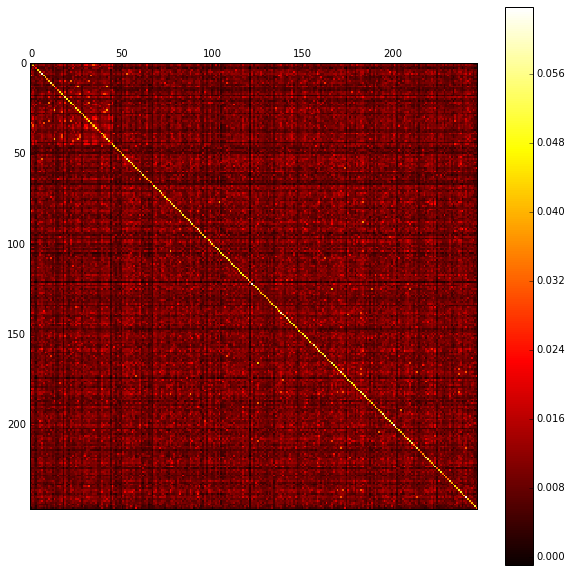

In [16]:
plot_covariance_matrix(feature_covariance_matrix)

## Plot Covariance Matrix on Hidden Layer (After Normalization)

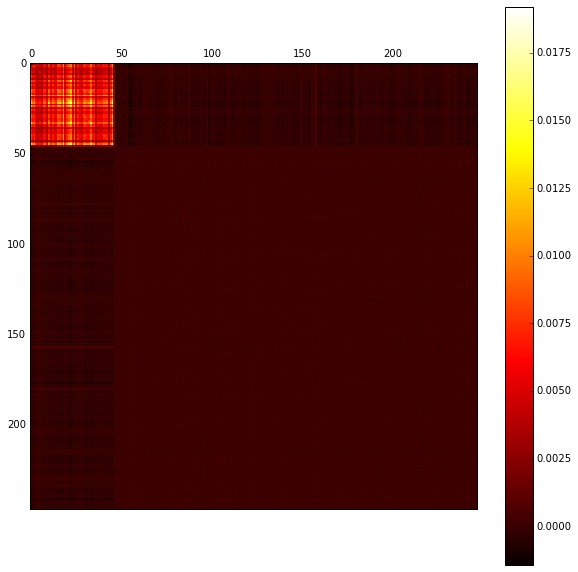

In [17]:
plot_covariance_matrix(hidden_covariance_matrix)

## Plot T-SNE on Hidden Layer

In [18]:
t = TSNE(n_components=2, random_state=0)
print 'Hidden shape:\t', hidden_X.shape
t_SNE_mapping = t.fit_transform(hidden_X)
print 't_SNE shape:\t',t_SNE_mapping.shape

Hidden shape:	(247, 2000)
t_SNE shape:	(247, 2)


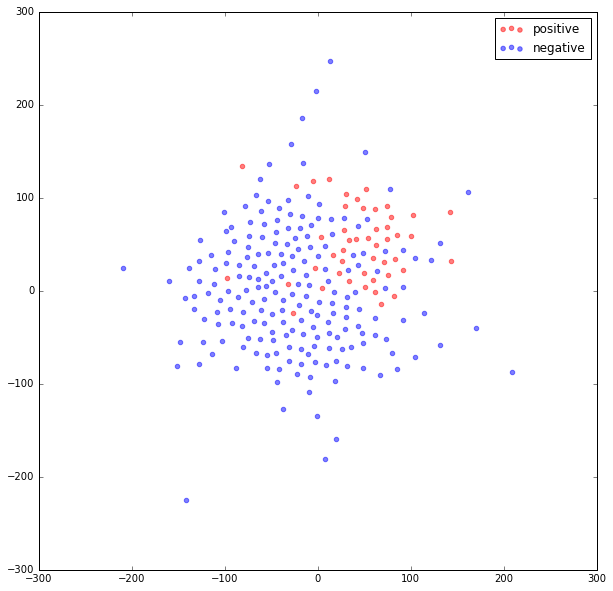

In [19]:
plt.scatter(t_SNE_mapping[:pos_num, 0], t_SNE_mapping[:pos_num, 1],
            alpha=0.5, cmap=plt.cm.Spectral,
            color='red', label='positive')
plt.scatter(t_SNE_mapping[pos_num:, 0], t_SNE_mapping[pos_num:, 1],
            alpha=0.5, cmap=plt.cm.Spectral,
            color='blue', label='negative')
plt.legend()
plt.show()

## Color Mapping for Covariance/Cosine Similarity Matrix

<table>
    <caption>Output Format</caption>
    <tr>
        <td></td><td>pos</td><td>neg</td>
    </tr>
    <tr>
        <td>pos</td><td bgcolor=#66ff66 /></td><td bgcolor=#ffff99 />
    </tr>
    <tr>
        <td>neg</td><td bgcolor=#ffff99 /></td><td bgcolor=#66ffff />
    </tr>
</table>

In [20]:
# Markdown(get_highlighted_markdown_table(hidden_covariance_matrix, pos_num))

# Test Multi-task Covariance Matrix

In [21]:
# directory = '../../dataset/keck_pcba/fold_{}/'.format(k)
# file_list = []
# for i in range(k):
#     file_list.append('{}file_{}.csv'.format(directory, i))
# file_list = np.array(file_list)

# # read data
# test_index = running_index / 4
# val_index = running_index % 4 + (running_index % 4 >= test_index)
# complete_index = np.arange(k)
# train_index = np.where((complete_index != test_index) & (complete_index != val_index))[0]

# train_file_list = file_list[train_index]
# val_file_list = file_list[val_index:val_index+1]
# test_file_list = file_list[test_index:test_index+1]

In [22]:
# train_pd = read_merged_data(train_file_list)
# train_pd.fillna(0, inplace=True)
# val_pd = read_merged_data(val_file_list)
# val_pd.fillna(0, inplace=True)
# test_pd = read_merged_data(test_file_list)
# test_pd.fillna(0, inplace=True)

# multi_name_list = train_pd.columns[-128:].tolist()
# multi_name_list.extend(label_name_list)
# print 'multi_name_list ', multi_name_list

# X_train, y_train = extract_feature_and_label(train_pd,
#                                              feature_name='Fingerprints',
#                                              label_name_list=multi_name_list)
# X_val, y_val = extract_feature_and_label(val_pd,
#                                          feature_name='Fingerprints',
#                                          label_name_list=multi_name_list)
# X_test, y_test = extract_feature_and_label(test_pd,
#                                            feature_name='Fingerprints',
#                                            label_name_list=multi_name_list)

In [23]:
with open('../virtual-screening/output/cross_validation/multi_classification_15.json', 'r') as f:
        conf = json.load(f)
multi_task = MultiClassification(conf=conf)

In [24]:
PMTNN_weight_file = '../virtual-screening/output/cross_validation/multi_classification_15/45983730/{}.weight'.format(running_index)
print PMTNN_weight_file
multi_task.predict_with_existing(X_train, y_train, X_val, y_val, X_test, y_test,
                                 PMTNN_weight_file=PMTNN_weight_file,
                                 score_file='temp_score.csv')

../virtual-screening/output/cross_validation/multi_classification_15/45983730/1.weight
train precision: 0.955737027534
train roc: 0.999936277071
train bedroc: 0.994096968205

validation precision: 0.224724213465
validation roc: 0.929668060547
validation bedroc: 0.69976630911

test precision: 0.140855422984
test roc: 0.836322995853
test bedroc: 0.706154699821

ratio: 0.02, EF: 34.375,	active: 16.0
ratio: 0.01, EF: 68.75,	active: 16.0
ratio: 0.0015, EF: 250.0,	active: 16.0
ratio: 0.001, EF: 125.0,	active: 16.0


In [25]:
multi_model = multi_task.setup_model()
multi_model.load_weights(PMTNN_weight_file)

### Output 2 Norm for Weight Matrix

In [26]:
for layer in multi_model.layers:
    if isinstance(layer, Dense):
        weights = layer.get_weights()
#         for i in range(len(weights)):
#             print i, 'dimension\t', weights[i].shape
        weight_matrix = weights[0]
        bias_matrix = weights[1]
        
        if layer == multi_model.layers[-1]: # Special case for last layer, only need task-related weight matrix
            weight_matrix = weight_matrix[:, -1]
            bias_matrix = bias_matrix[-1].reshape(1,)
            weights = np.hstack((weight_matrix, bias_matrix))
        else:
            weights = np.vstack(weights)
        
        induced_2_norm = LA.norm(weights)
        print 'Weight matrix norm for this layer is\t', induced_2_norm

Weight matrix norm for this layer is	38.3292
Weight matrix norm for this layer is	45.945
Weight matrix norm for this layer is	2.95481


### Pop-up Last Output Layer

In [27]:
output_layer = multi_model.layers.pop()
dropout_2nd = multi_model.layers.pop()
dense_2nd = multi_model.layers.pop()
multi_model.outputs = [multi_model.layers[-1].output]
multi_model.layers[-1].outbound_nodes = []
print multi_model.layers

[<keras.layers.core.Dense object at 0x7f1ba49c9690>, <keras.layers.core.Dropout object at 0x7f1ba2825790>, <keras.layers.core.Dense object at 0x7f1ba4998a10>]


## Save Multi-task Matrix

In [28]:
hidden_pos_X = multi_model.predict(sample_pos_X)
hidden_neg_X = multi_model.predict(sample_neg_X)
hidden_X = np.vstack((hidden_pos_X, hidden_neg_X))
print hidden_X.shape

(247, 2000)


In [29]:
hidden_covariance_matrix = np.cov(hidden_X)
hidden_cosine_matrix = get_distance_metrics(hidden_X)

In [30]:
book = Workbook(style_compression=2)
book_set_custom_colour(book)

sheet = book.add_sheet('Covariance_Matrix_Hidden_Layer')
sheet_write_matrix(sheet, hidden_covariance_matrix, pos_num)

sheet = book.add_sheet('Covariance_Matrix_Input_feature')
sheet_write_matrix(sheet, feature_covariance_matrix, pos_num)

sheet = book.add_sheet('Cosine_Matrix_Hidden_Layer')
sheet_write_matrix(sheet, hidden_cosine_matrix, pos_num)

sheet = book.add_sheet('Cosine_Matrix_Input_feature')
sheet_write_matrix(sheet, feature_cosine_matrix, pos_num)

book.save('plottings/multi_task_running_{}.xls'.format(running_index))

## Plot Covariance Matrix on Feature (After Normalization)

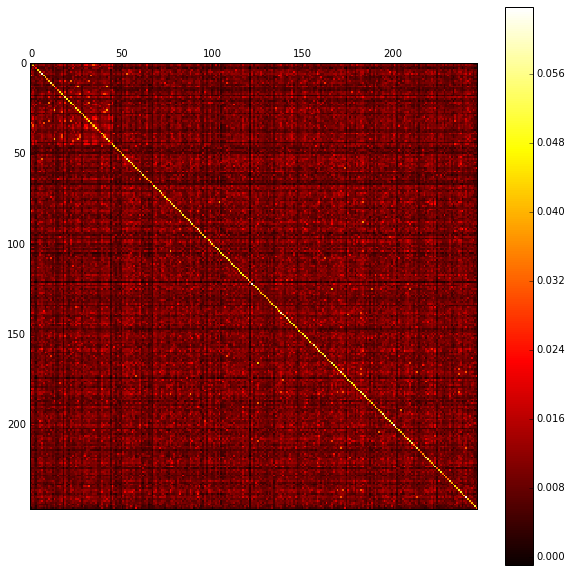

In [31]:
plot_covariance_matrix(feature_covariance_matrix)

## Plot Covariance Matrix on Hidden Layer (After Normalization)

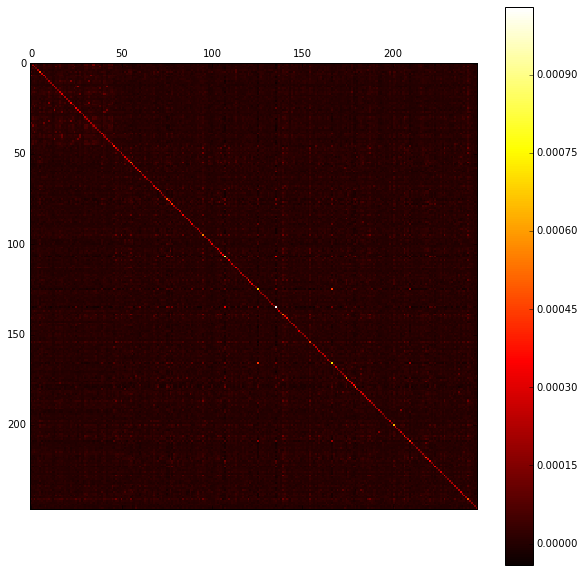

In [32]:
plot_covariance_matrix(hidden_covariance_matrix)

## Plot T-SNE on Hidden Layer

In [33]:
t = TSNE(n_components=2, random_state=0)
print 'Hidden shape:\t', hidden_X.shape
t_SNE_mapping = t.fit_transform(hidden_X)
print 't_SNE shape:\t',t_SNE_mapping.shape

Hidden shape:	(247, 2000)
t_SNE shape:	(247, 2)


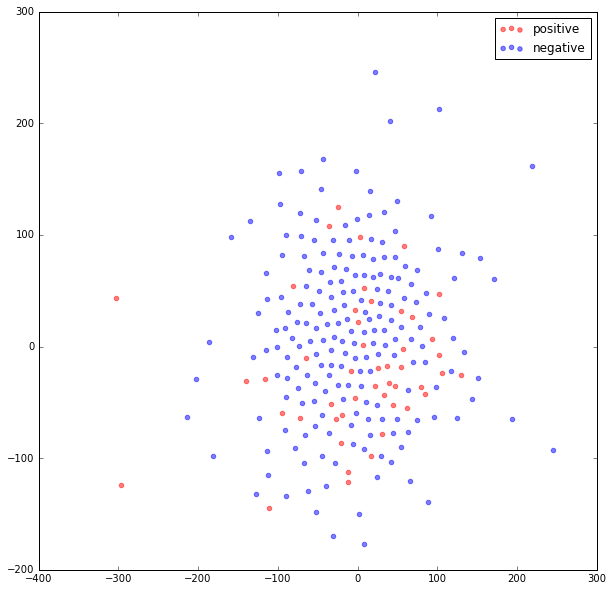

In [34]:
plt.scatter(t_SNE_mapping[:pos_num, 0], t_SNE_mapping[:pos_num, 1],
            alpha=0.5, cmap=plt.cm.Spectral,
            color='red', label='positive')
plt.scatter(t_SNE_mapping[pos_num:, 0], t_SNE_mapping[pos_num:, 1],
            alpha=0.5, cmap=plt.cm.Spectral,
            color='blue', label='negative')
plt.legend()
plt.show()